#Image Consistency Estimator:
Train with triplets of 28x28 patches from real images
- Triplet of patches (same-1, same-2, diff)
- Contrastive loss on a siamese network

Train with pairs of 40x40 patches from real and fake images
- One in top-left, one in bottom-right, both 40x40, sharing one 28x28 square in the center.

The network is trained on it along with training on patch-consistency.


In [0]:
# Importing useful libraries
import math
import os
import random
import torch
import cv2
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torchvision import datasets, models, transforms

from datetime import datetime
from torch.utils.data import DataLoader, Dataset, IterableDataset
from tqdm.auto import tqdm
from tqdm.notebook import tqdm as new_tqdm

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from google.colab.patches import cv2_imshow
import numpy as np
import copy
import gc #gc is garbage collector.

#used in feature extraction
from itertools import accumulate  # to cumulatively sum a list
import bisect # bisect needed for finding index of the first element bigger than given input.
import random # needed for shuffling

## Mount Shared Drive

In [2]:
# Mount Shared Drive for project to /content/drive/ folder
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Global Variables

In [3]:
# Torch variables
global_dtype = torch.float32  #Changed on purpose to save memory issues.
global_device = "cuda"
local_device="cpu"
print(f"We will be using global dtype = {global_dtype} and global device = {global_device}")
if torch.cuda.is_available():
  print ("CUDA is available!")

# Image transform variables
image_resize = 224 # Resize all images to be 224 x 224
image_crop = 224 
image_center_crop = 256
image_rotate = 10 # Rotate images randomly +/- 10 degrees (not used)
image_mean = torch.tensor([0.485, 0.456, 0.406])
image_std= torch.tensor([0.229, 0.224, 0.225])

We will be using global dtype = torch.float32 and global device = cuda
CUDA is available!


**List of Number of Available Images:**

```
Fouhey -> originals -> real -> 1580
Refined -> Flicker30K -> real -> 2820
Refined -> PS_battles -> real -> 1500
Total Real Images: 5900

Fouhey -> a_0000 -> fake -> 800
Fouhey -> b_0001-> fake -> 800
Fouhey -> c_0002-> fake -> 400
Refined -> PS_battles -> fake -> a_000 -> 500
Refined -> PS_battles -> fake -> z_0011 -> 1800
Refined -> PS_battles -> fake -> z_0012 -> 1600
Total Fake Images: 5900

```
**Data Credits:**
We thank Prof. David Fouhey for his collection of Real and Fake images. We are grateful to Prof. Andrew Owens for making available these datsets and suggestions for other datasets and augmentation techniques.


# Define Dataset Class

In [0]:
# This is needed even if we directly load the loaders from saved files.
# We will use this class to create datasets containing image tensors and their labels
class ImageTensorDataset(Dataset):
  # We do not need transform member since we preprocessed already
  def __init__ (self, image_tensors, labels, augment=False):
    self.image_tensors = image_tensors
    self.labels = labels    
    
  # Used to index the dataset [#]
  def __getitem__(self, index):
        
    # else: 
    image_tensor = self.image_tensors[index]#self.transform()#.cuda()
    label = self.labels[index]
    return image_tensor, label

  # Used to count how many tensors are in the dataset
  def __len__(self):
    return len(self.image_tensors)

# This is needed even if we directly load the loaders from saved files.
# We will use this class to create datasets containing image tensors and their labels
class ImageTensorDataset_noaugment(Dataset):
  # We do not need transform member since we preprocessed already
  def __init__ (self, image_tensors, labels, augment=False):
    self.image_tensors = image_tensors
    self.labels = labels    
    
  # Used to index the dataset [#]
  def __getitem__(self, index):
        
    # else: 
    image_tensor = self.image_tensors[index]#self.transform()#.cuda()
    label = self.labels[index]
    return image_tensor, label

  # Used to count how many tensors are in the dataset
  def __len__(self):
    return len(self.image_tensors)

#Load DataLoaders




In [0]:
# # Loading the Saved DataLoaders:
train_loader_file="/content/drive/Shared drives/EECS504/Saved_Objects/train_loader_P3_A4_5900_28x28-5_1pair_64_2020-04-18_193021.pt"
val_loader_file="/content/drive/Shared drives/EECS504/Saved_Objects/val_loader_P3_A4_5900_28x28-5_1pair_64_2020-04-18_193309.pt"
test_loader_file="/content/drive/Shared drives/EECS504/Saved_Objects/test_loader_P3_A4_5900_28x28-5_1pair_64_2020-04-18_193604.pt"

train_loader = torch.load(train_loader_file)
val_loader = torch.load(val_loader_file)
test_loader = torch.load(test_loader_file)

In [0]:
#custom loaders: download only full_train loader.
custom_full_train_file="/content/drive/Shared drives/EECS504/Saved_Objects/MW/Custom_Full_train_loader_P3_A5_3000_3000_64_40x40to28x28.pt"

custom_train_loader = torch.load(custom_full_train_file)

In [12]:
print(len(train_loader),len(val_loader)) #,len(test_loader))
print(len(custom_train_loader))

111 37
94


# Network Setup - The Consistency Estimator:

###Weight Initialization:

In practice, the current recommendation is to use ReLU units and use the 
```w = np.random.randn(n) * sqrt(2.0/n)```, as discussed by Kaiming He and others at:
http://arxiv-web3.library.cornell.edu/abs/1502.01852

A short overview on different types of initializations:
https://cs231n.github.io/neural-networks-2/#init

A full lecture on weight initialization and other setup:
https://web.eecs.umich.edu/~justincj/slides/eecs498/498_FA2019_lecture10.pdf

$$ W = \sqrt{2} * {Gaussian(D_{in},D_{out})} / {\sqrt{D_{in}}} $$

The concept of $1/ \sqrt{D_{in}}$  is taken from the Xavier Initialization (2010). Kaiming Initialization is more recent version (2015).

$$\text{ Since we have only 4-5 convolution layers and 2-3 linear layers,}$$
$${\text{Batch-normalization and proper Weight Initialization will remove the need of Residual Skip Connections.  }}$$

In [14]:
class Estimator(nn.Module):
  """
  Estimates consistency between pairs of patches. 

  """
  def __init__(self,verbose=False):
    super().__init__()
    #input N x 64 x H x W . Typically  H x W = 28 x 28.
    self.fc1=nn.Linear(512,8 )
    self.lr=nn.LeakyReLU(0.02)
    self.fc2=nn.Linear(8,2)    

    nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='leaky_relu' )
    nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='leaky_relu')
    
    self.estm =nn.Sequential( 
    nn.Conv2d(64, 128, (3,3),stride=2,padding=1),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.02),
    nn.MaxPool2d((3,3),stride=2,padding=1), #downsample -> 15x15

    nn.Conv2d(128, 256, (3,3),stride=1,padding=1),
    
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.02),
    nn.MaxPool2d((3,3),stride=2,padding=1),  #downsample -> 8x8

    nn.Conv2d( 256,512, (3,3),stride=1,padding=1),
    
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.02),
    nn.MaxPool2d((3,3),stride=2,padding=1), #downsample -> 4x4   

    nn.AdaptiveAvgPool2d((1,1)),  #downsample -> 1x1
    # N x 128 x 1 x 1 
    nn.Flatten()) #-> N x 128
    
    #initialize:
    for m in self.estm.modules():
      if isinstance(m, nn.Conv2d):
        print("conv",m)
        nn.init.kaiming_normal_(m.weight, mode='fan_out', a=0.02, nonlinearity='leaky_relu')

      elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        print("batch-norm",m)
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    
      elif isinstance(m,nn.Linear):
        print("linear",m)
        nn.init.kaiming_normal_(m.weight, mode='fan_out', a=0.02, nonlinearity='leaky_relu')    

    if verbose==True:
      summary(self.estm.cuda(), (64, 28, 28),device=global_device)

  def forward(self, x):  # Siamese Structure  x = Nx(64*2)x28x28, passed 64 channels at once.
    self.cuda()
    local_dtype=x.dtype
    local_device=x.device
    
    out_p1=self.lr(self.fc1(self.estm(x[:,:64,:,:]).squeeze().squeeze()))  #Nx32
    out_p2=self.lr(self.fc1(self.estm(x[:,64:,:,:]).squeeze().squeeze()))  #Nx32
    out=torch.abs(out_p2-out_p1)

    scores=self.fc2(out) #Nx2
    scores=scores.to(device=local_device,dtype=local_dtype) 
    
    return scores

net1=Estimator(verbose=True).cuda()

conv Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
batch-norm BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
conv Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
batch-norm BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
conv Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
batch-norm BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]          73,856
       BatchNorm2d-2          [-1, 128, 14, 14]             256
         LeakyReLU-3          [-1, 128, 14, 14]               0
         MaxPool2d-4            [-1, 128, 7, 7]               0
            Conv2d-5            [-1, 256, 7, 7]         295,168
       BatchNorm2d-6            [-1, 256, 7, 7]          

# Setting-up the Training Process
Earlier versions have been moved to Partial_Backup.ipynb

In [0]:
class Assembly(): 
  """
  Processing assembly-line that defines how the model training/ testing commands 
  will be executed.
  """
  ### Calculate Accuracy: Validation/ Testing Commands
  def check_accuracy(self,loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    accurate_labels = 0
    all_labels = 0

    for  t, (x, y) in enumerate(loader):
      x = x.to(device='cuda', dtype=torch.float32)  # move to device, e.g. GPU
      y = y.to(device='cuda', dtype=torch.long)

      pair0 = x[:,:128]
      out0=model(pair0).squeeze().to(dtype=global_dtype)
      target0 = y[:,0].type(torch.LongTensor).to(device=global_device)

      pair1 = torch.cat((x[:,0:64],x[:,128:192]),dim=1)
      out1=model(pair1).squeeze().to(dtype=global_dtype)
      target1 = y[:,1].type(torch.LongTensor).to(device=global_device)
      
      accurate_labels_positive = torch.sum(torch.argmax(out0, dim=1) == target0)
      accurate_labels_negative = torch.sum(torch.argmax(out1, dim=1) == target1)
          
      accurate_labels = accurate_labels + accurate_labels_positive + accurate_labels_negative
      all_labels = all_labels + len(target0) + len(target1)
      if t==0:
        print(torch.max(out0),torch.min(out0),torch.max(out1),torch.min(out1),torch.max(target0),torch.min(target0),torch.max(target1),torch.min(target1))
    
    acc = 100. * accurate_labels / all_labels
    acc=np.round(acc.cpu(),4)
       
    accurate_labels2 = 0
    all_labels2 = 0
    for  z, (x2, y2) in enumerate(custom_train_loader):
      x2 = x2.to(device='cuda', dtype=torch.float32)  # move to device, e.g. GPU
      y2 = y2.to(device='cuda', dtype=torch.long)
      pair2 = x2
      out2=model(pair2).squeeze().to(dtype=global_dtype)
      target2 = y2.type(torch.LongTensor).to(device=global_device)
      accurate_labels_positive = torch.sum(torch.argmax(out2, dim=1) == target2)

      accurate_labels2 = accurate_labels2 + accurate_labels_positive
      all_labels2 = all_labels2 + len(target2)
    
    acc2 = 100. * accurate_labels2 / all_labels2
    print('Consistency Accuracy: {}/{} ({:.3f}%) \t and Real vs. Fake Accuracy: {}/{} ({:.3f}%) '\
          .format(accurate_labels, all_labels, acc,accurate_labels2,all_labels2,acc2))
    
    acc2=np.round(acc2.cpu(),4)
    
    return acc,acc2

  def adjust_learning_rate(self,optimizer, lr_decay, epoch, schedule):
    """
    Multiply lr_decay to the learning rate if epoch is in schedule
  
    Inputs:
    - optimizer: An Optimizer object we will use to train the model
    - lr_decay: learning rate decay; can be a list or just a single number.
      a factor multiplied with present learning rate at scheduled epochs (fpor example, 0.95*learning_rate)
    - epochs: the current epoch number
    - schedule: the list of epochs that requires learning rate update
  
    Returns: Nothing, but learning rate might be updated
    """
    schedule=sorted(schedule) #sort the lr_schedule.
    if epoch in schedule:
      for param_group in optimizer.param_groups:
        if type(lr_decay) is list:
          if len(lr_decay)>=schedule.index(epoch)+1: # if length of lr_decay list is greater than or equal to length of the lr_schedule
            decay_factor=lr_decay[schedule.index(epoch)]
          else:
            decay_factor=lr_decay[-1] #the last decay_factor available in the lr_decay list.
        else:
          decay_factor=lr_decay #If not a list.        
        
        print('                                            \
        lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * decay_factor)) #printed before updating.
        param_group['lr'] *= decay_factor #updated.

  def model_run(self,model, loader, optimizer, train_flag=False, v_loader=val_loader, \
                epochs=1, lr_scheduler='manual',lr_schedule=[],lr_decay=.95, num_patience=1, \
                verbose=True):  
    """
    Train a model on dataset using the PyTorch Module API.
  
    Inputs:
    - model: A PyTorch module giving the model to train.
    - loader: Train-loader or Test-loader
    - v_loader: Loader to check validation accuracy against, during training. 
                Default = default validation loader. Only changes during toy-training.
                Ignored during testing.
    - optimizer: An Optimizer object we will use to train the model
    - train_flag: should be set to 'True' while training, default='False'.
    - epochs: (Optional) A Python integer giving the number of epochs to train for.
              Testing only runs for 1 epoch, value of epochs is disregarded. 
    - lr_scheduler== 'manual': uses self.adjust_learning_rate() function to decay
                               the learning rate by multiplying it with 'lr_decay' value for 
                               epochs scheduled in 'lr_schedule' list.
    - lr_decay: value (can be a list in 'manual' mode) multiplied with existing learning rate to decrease it.                           
    - lr_schedule: list of epochs when learning rate is reduced. ex. [8,16].

    - lr_scheduler=='auto': uses optim.lr_scheduler.ReduceLROnPlateau() to automatically
                            reduce the learning rate by multiplying it with 'lr_decay' when 
                            it starts plateauing, after waiting for 'num_patience' epochs.
    - num_patience: number of epochs to wait for before reducing the learning rate.

    See that lr_decay is used with both types of lr_scheduler but its value may be drastically
    different for both based on when they reduce the learning rate.
    Example case: 
    lr_scheduler= 'manual', lr_decay=0.9 
    lr_scheduler= 'auto', lr_decay=0.1.
    Further, lr_decay can be a list in 'manual' mode, as we might want to apply different decay at different epochs.

    Output(s): 
    if train_flag==1:
      acc_history, iter_history,loss_list
    else:
      acc_history: just one test-accuracy value.

    """
    loss_class = nn.BCELoss()
    if train_flag==True:
      model.train()  # put model to training mode
    else:      
      model.eval()   # put model to testing mode.
   
    loss_list=[]
    print_every = 10  #print accuracy at every x number of iterations.
    model = model.to(device=global_device)  # move the model parameters to CPU/GPU
    num_iters = epochs * len(loader)
  
    if verbose:
      num_prints = num_iters // print_every + 1
    else:
      num_prints = epochs
  
    acc1_history = torch.empty(num_prints, dtype=global_dtype, device=global_device)
    acc2_history = torch.empty(num_prints, dtype=global_dtype, device=global_device)
    iter_history = torch.empty(num_prints, dtype=torch.long, device=global_device) 
    # best_acc1=0
    # best_acc2=0
    best_acc1, best_acc2 = self.check_accuracy(v_loader, model)
    best_model_wts = copy.deepcopy(model.state_dict()) 

    if train_flag==True: #Training: Multiple Epochs. (Testing -> only one epoch.)
      model.requires_grad_(requires_grad=True)
      print("ESTM parameters being trained: ")
      for name, child in model.named_children():
        for name_2, params in child.named_parameters():
          print(name_2, params.requires_grad)

      if lr_scheduler == 'auto':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', lr_decay, num_patience, verbose)

      for e in new_tqdm(range(epochs)):
        custom_iterator = iter(custom_train_loader) #create one iterator in each epoch. 
        if lr_scheduler == 'manual':
          self.adjust_learning_rate(optimizer, lr_decay, e, lr_schedule)
    
        for t, (x, y) in enumerate(loader):   
         
          x=x.cuda()
          y=y.type(torch.LongTensor).cuda()
          
          x.requires_grad = True         

          # Zero out all of the gradients before running a fresh iteration so that 
          # no cached gradients affect this computation.
          optimizer.zero_grad()

          pair0 = x[:,:128]   #first and second patches from the same image
          out0=model(pair0).squeeze().to(dtype=global_dtype)
          target0 = y[:,0].to(device=global_device)          
          loss0 = F.cross_entropy(out0,target0)


          pair1 = torch.cat((x[:,0:64],x[:,128:192]),dim=1)   #first and third patches from the same image
          out1=model(pair1).squeeze().to(dtype=global_dtype)
          target1 = y[:,1].to(device=global_device)
          loss1 = F.cross_entropy(out1,target1)

          loss_part1=loss0+loss1 

          if t< len(custom_train_loader):
            X2,y2 = next(custom_iterator)
            X2=X2.cuda()
            y2=y2.type(torch.LongTensor).cuda()            
            X2.requires_grad = True                          
                       
            out2=model(X2).squeeze().to(dtype=global_dtype)
            
            loss_part2 = F.cross_entropy(out2,y2)
            loss=loss_part1+2*loss_part2 #real versus fake loss needs to be the main focus while backprop.
          
          else:
            loss=loss_part1

          # This is the backwards pass: compute the gradient of the loss with
          # respect to each  parameter of the model.
          loss.backward()

          # Update the parameters of the model using the gradients
          # computed by the backwards pass.
          optimizer.step()          
          
          loss_list.append(loss.item())#.item() helps detatching the computational graphs and helps reduce memory leaks.
          
          tt = t + e * len(loader)
          print("loss: ", loss.item(), "Epoch: ", e, "Iteration: ", tt)              
          
          if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(loader)-1)):
            acc1,acc2 = self.check_accuracy(v_loader, model)            
            acc1_history[tt // print_every] = acc1
            acc2_history[tt // print_every] = acc2
            iter_history[tt // print_every] = tt

            if acc1 >= best_acc1 and acc2>=best_acc2:
              best_acc1 = acc1
              best_acc2 = acc2
              best_model_wts = copy.deepcopy(model.state_dict()) 
        
          elif not verbose and (t == len(loader)-1): #Keep >= to have a little 'or' margin.
            acc = self.check_accuracy(v_loader, model)            
            acc1_history[e] = acc1
            acc2_history[e] = acc2
            iter_history[e] = tt

            if acc1 >= best_acc1 and acc2>=best_acc2:
              best_acc1 = acc1
              best_acc2 = acc2
              best_model_wts = copy.deepcopy(model.state_dict())                
        
        if lr_scheduler == 'auto':
          scheduler.step(loss)

      if acc1_history[-1]==0:
        if (len(acc1_history) == len(iter_history)
            or len(acc2_history) == len(iter_history)):
          iter_history = iter_history[:-1]
        
        acc1_history=acc1_history[:-1]
        acc2_history=acc2_history[:-1]

      
    else: #Inference (testing)
        with torch.no_grad():

          acc1_history,acc2_history = torch.tensor(self.check_accuracy(loader, model), dtype=global_dtype, device=global_device) #just one value.

    if train_flag==True:
      model.load_state_dict(best_model_wts)
      best_model=model
      best_params=copy.deepcopy(optimizer.state_dict()) 
      
      return acc1_history,acc2_history, iter_history,loss_list,best_model,best_params
    else:
      return acc1_history,acc2_history

#Training:

conv Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
batch-norm BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
conv Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
batch-norm BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
conv Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
batch-norm BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
tensor(7.8833, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-1.7319, device='cuda:0', grad_fn=<MinBackward1>) tensor(8.3197, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.8786, device='cuda:0', grad_fn=<MinBackward1>) tensor(0, device='cuda:0') tensor(0, device='cuda:0') tensor(1, device='cuda:0') tensor(1, device='cuda:0')
Consistency Accuracy: 3742/4720 (79.280%) 	 and Real vs. Fake Accuracy: 3027/6000 (50.450%) 
ESTM parameters being trained: 
weight True
bias True
weight True
bias True
0.w

loss:  2.3103392124176025 Epoch:  0 Iteration:  0
tensor(5.0171, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-1.0376, device='cuda:0', grad_fn=<MinBackward1>) tensor(9.1547, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-1.0105, device='cuda:0', grad_fn=<MinBackward1>) tensor(0, device='cuda:0') tensor(0, device='cuda:0') tensor(1, device='cuda:0') tensor(1, device='cuda:0')
Consistency Accuracy: 3738/4720 (79.195%) 	 and Real vs. Fake Accuracy: 3034/6000 (50.567%) 
loss:  2.864546775817871 Epoch:  0 Iteration:  1
loss:  2.7030930519104004 Epoch:  0 Iteration:  2
loss:  2.541677236557007 Epoch:  0 Iteration:  3
loss:  2.3485474586486816 Epoch:  0 Iteration:  4
loss:  3.2838242053985596 Epoch:  0 Iteration:  5
loss:  2.435338258743286 Epoch:  0 Iteration:  6
loss:  2.5962562561035156 Epoch:  0 Iteration:  7
loss:  3.1404685974121094 Epoch:  0 Iteration:  8
loss:  2.5919089317321777 Epoch:  0 Iteration:  9
loss:  2.519399404525757 Epoch:  0 Iteration:  10
tensor(7.7001, device='cud

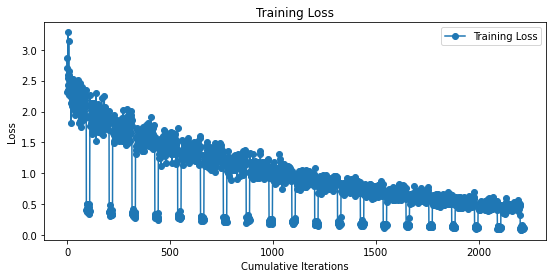

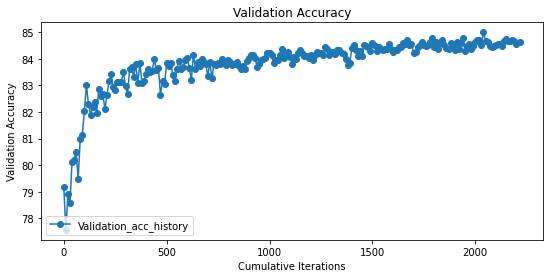

tensor([79.1949, 77.5636, 78.8983, 78.5593, 80.1059, 80.1907, 80.4873, 79.4915,
        80.9958, 81.1441, 82.0339, 83.0085, 82.3093, 81.8856, 82.2034, 82.3729,
        81.9703, 82.8814, 82.6059, 82.6695, 82.0975, 82.6271, 83.1780, 83.4110,
        82.9237, 82.8390, 83.1144, 83.1144, 83.1356, 83.5169, 82.9661, 82.6907,
        83.6017, 83.6864, 83.3263, 83.7924, 83.0932, 83.8559, 83.0720, 83.1780,
        83.4322, 83.6017, 83.5169, 83.5593, 83.9830, 83.5805, 83.6441, 82.6483,
        83.1780, 83.0508, 83.8348, 83.7288, 83.8348, 83.3898, 83.1780, 83.6017,
        83.9195, 83.6017, 83.7076, 83.9407, 84.0254, 83.6652, 83.2203, 84.1314,
        83.6229, 83.8983, 83.7288, 84.0042, 83.8771, 83.7924, 83.3686, 83.8771,
        83.2627, 83.8136, 83.7500, 83.8348, 83.8136, 84.0042, 83.8559, 83.7712,
        83.9619, 83.8771, 83.7500, 83.8136, 83.8771, 83.7288, 83.6017, 83.7288,
        83.6229, 83.9195, 84.0254, 84.1314, 84.1525, 84.0254, 83.7076, 83.7924,
        83.9619, 83.9830, 84.0466, 84.21

In [22]:
"""
Training Commands. Hyperparameters can be tuned for performance. \
Do not forget to save the trained model by uncommenting the next cell.
"""

assembly=Assembly()
# Be patient while training the model, it is a large model. 
# Training will take some time, stay tuned.

# Optimizer hyperparameters 
learning_rate = 1e-4       
reg =0.001      # coefficient in front of ||W||^2 (= lambda of L2 regularization term.)
momentum = 0.9    # Model hyperparameters
train_epochs=20
lr_schedule=[]
lr_decay=[]

torch.autograd.set_detect_anomaly(True) #enabled anomaly detection to find the operation that failed to compute its gradient

model2 = Estimator().to(device=global_device, dtype=global_dtype)
model2.load_state_dict(torch.load("/content/drive/Shared drives/EECS504/Trained_Models/MW/P3_A4_model-28x28-5_one_pair-batch_size_64_train_99.9718_val_85.4661_test_acc_85.4661.pt"))

optimizer = optim.SGD(model2.parameters(), lr=learning_rate, weight_decay=reg,momentum=momentum,nesterov=False )

acc1_history,acc2_history, iter_history,loss_list,best_model2,best_params2 = assembly.model_run(model2, train_loader, optimizer, train_flag=True, \
                                                v_loader=val_loader, epochs=train_epochs,lr_scheduler='manual',lr_schedule=lr_schedule,lr_decay=lr_decay)

# plot the Training Loss vs. iterations
plt.plot(loss_list, '-o')
plt.legend(['Training Loss'], loc='upper right')
plt.xlabel('Cumulative Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.gcf().set_size_inches(9, 4)
plt.show()

# plot the Validation Accuracy vs. iterations
plt.plot(list(iter_history[:-1]),list(acc1_history[:-1]), '-o')
plt.legend(['Validation_acc_history'], loc='lower left')
plt.xlabel('Cumulative Iterations')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()
print(acc1_history)


In [21]:
train_acc1,overfit_acc2=assembly.model_run(best_model2, train_loader, optimizer, train_flag=False,epochs=1)
val_acc,overfit_acc2 = assembly.model_run(best_model2, val_loader, optimizer, train_flag=False,epochs=1)
test_acc,overfit_acc2 = assembly.model_run(best_model2, test_loader, optimizer, train_flag=False,epochs=1)

tensor(7.5602, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-1.3636, device='cuda:0', grad_fn=<MinBackward1>) tensor(9.8805, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-2.9611, device='cuda:0', grad_fn=<MinBackward1>) tensor(0, device='cuda:0') tensor(0, device='cuda:0') tensor(1, device='cuda:0') tensor(1, device='cuda:0')
Consistency Accuracy: 4016/4720 (85.085%) 	 and Real vs. Fake Accuracy: 5835/6000 (97.250%) 
tensor(9.6817, device='cuda:0') tensor(-2.2099, device='cuda:0') tensor(8.3869, device='cuda:0') tensor(-2.1373, device='cuda:0') tensor(0, device='cuda:0') tensor(0, device='cuda:0') tensor(1, device='cuda:0') tensor(1, device='cuda:0')
Consistency Accuracy: 14131/14160 (99.795%) 	 and Real vs. Fake Accuracy: 5835/6000 (97.250%) 
tensor(6.4461, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-2.2463, device='cuda:0', grad_fn=<MinBackward1>) tensor(9.2415, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-1.5288, device='cuda:0', grad_fn=<MinBackward1>) tensor(0, devi

#**Saving the trained model:**
###Instructions:
The following command, when uncommented, will save the above trained model to Google Drive in a secured place such that this trained model can be accessed by this and any other notebooks.

**1. Uncomment the following cell and run it.**   
**2. Comment it back to remove the possiblity of accidental overwriting.**


In [0]:
# model_save_name = f"P3_A5_standard_model_40x40to28x28_2xloss_train_{train_acc1:.7}_val_{val_acc:.7}_test_acc_{test_acc:.7}_part2_{overfit_acc2:.7}.pt"
# path = F"/content/drive/Shared drives/EECS504/Trained_Models/MW/{model_save_name}" 
# torch.save(best_model2.state_dict(), path)

# params_save_name = f"P3_A5_best_params_standard_model_40x40to28x28_2xloss_train_{train_acc1:.7}_val_{val_acc:.7}_test_acc_{test_acc:.7}_part2_{overfit_acc2:.7}.pt"
# path2 = F"/content/drive/Shared drives/EECS504/Trained_Models/MW/{params_save_name}" 
# torch.save(best_params2['param_groups'],path2)  #re-load what you save and see that it is well-saved!